<a href="https://colab.research.google.com/github/tw9213/Geant4/blob/master/New_Ekman_transport_ipynbb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install weave

    100% |████████████████████████████████| 573kB 4.9MB/s 
  Running setup.py bdist_wheel for weave ... - \ | done
  Stored in directory: /root/.cache/pip/wheels/8b/b7/53/287a0ab1034dd211f826411dd59f41de1b5ba00aec8cf6e4c7
Successfully built weave


In [0]:
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
import weave
from weave import converters

%matplotlib inline


In [0]:
class FluidDynamics(object):
  
  def __init__(self, r, nr, ntheta, nu, Omega, rho, G):
    
    self.dt = 0.001
    
    self.r = r
    self.nr = nr
    self.ntheta = ntheta
    self.nu = nu
    self.Omega = Omega
    self.rho = rho
    self.G = G
    
    self.dr = np.float(r[-1])/nr
    self.dtheta = 2*np.pi/ntheta
    
    self.vz = []
    self.vz.append(0)
    
    self.u_ctr = []
    self.u_b = []
    self.v_ctr = []
    self.v_b = []
    self.t_array = []
    
    self.t = 0
    
  #def trajectory(self, begin, end, init, u, v):
  #  
  def Chorins_method(self, t, u, v, p):
    
    nt = np.int(t/self.dt)
    
    for n in range(1, nt+1): ##loop across number of time steps
      
      u, v = self.intermediate_v(u, v)
      p = self.poisson(u, v, p)
      u, v = self.compensate(u, v, p)
      
      self.u_ctr.append(u[0, 1])
      self.v_ctr.append(v[0, 1])
      
      self.u_b.append(u[0, -2])
      self.v_b.append(v[0, -2])
      self.t_array.append(self.t + n*self.dt)
      
    self.t += t
    return u, v, p

  def intermediate_v(self, u, v):
    un = u.copy() 
    vn = v.copy()
    
    r = self.r
    nr = self.nr
    ntheta = self.ntheta
    dr = self.dr
    dtheta = self.dtheta
    dt = self.dt
    nu = self.nu
    Omega = self.Omega
    G = self.G
    
    code = """
    for (int i = 1; i < nr-2; ++i){
      for (int j = -1; j < ntheta - 1; ++j){

        int k, k1, k_1;
        if (j==-1 || j == 0){
          if (j<0){
            k = ntheta -1;
            k1 = 0;
            k_1 = ntheta -2;
          }else{
            k = 0;
            k1 = 1;
            k_1 = ntheta -1;
          }
        }else{
          k = j;
          k1 = j+1;
          k_1 = j-1;
        }

        u(k, i) = (un(k, i)
                  -dt*(un(k, i)*(un(k, i+1) - un(k, i-1))/(2*dr)
                  +vn(k, i)*(un(k1, i) - un(k_1, i))/(2*dtheta*r(i)) - vn(k, i)*vn(k, i)/r(i))
                  +nu*dt*((un(k, i+1) - 2 * un(k, i) + un(k, i-1))/(dr*dr)
                  +(un(k, i+1) - un(k, i-1))/(2*r(i)*dr)        
                  +(un(k1, i) - 2 * un(k, i) + un(k_1, i))/((r(i)*dtheta)*(r(i)*dtheta))
                  -un(k, i)/(r(i)*r(i)) - 2*(vn(k1, i) - vn(k_1, i))/(2*(r(i)*r(i))))
                  +2*dt*Omega(k, i)*vn(k, i));

        v(k, i) = (vn(k, i)
                  -dt*(un(k, i)*(vn(k, i+1) - vn(k, i-1))/(2*dr)
                  +vn(k, i)*(vn(k1, i) - vn(k_1, i))/(2*dtheta*r(i)) + un(k, i)*vn(k, i)/r(i))
                  +nu*dt*((vn(k, i+1) - 2 * vn(k, i) + vn(k, i-1))/(dr*dr)
                  +(vn(k, i+1) - vn(k, i-1))/(2*r(i)*dr)        
                  +(vn(k1, i) - 2 * vn(k, i) + vn(k_1, i))/((r(i)*dtheta)*(r(i)*dtheta))
                  -vn(k, i)/(r(i)*r(i)) + 2*(un(k1, i) - un(k_1, i))/(2*(r(i)*r(i))*dtheta))
                  -2*dt*Omega(k, i)*un(k, i) + dt*G(k, i));
      }
    } 
    """
    
  
    weave.inline(code, ['u','v','un','vn','r','nr','ntheta','dr','dtheta','dt','nu','Omega','G'], type_converters=converters.blitz, compiler='gcc')
    
    #print("v is", v)
    #print("vn is ",vn)
    #quat = np.int(self.ntheta/4)
    
    #for j in range(-1, self.ntheta-1):      
      #u[j, 0] = (un[j, 0]
      #          -self.dt*(un[j, 0]*(un[j, 1] - un[j-2*quat, 1]) + un[j-3*quat, 0]*(un[j-3*quat, 1] - un[j-quat, 1]))/(2*self.dr)
      #          +self.nu*self.dt*(un[j, 1] + un[j-3*quat, 1] + un[j-quat, 1] + un[j-2*quat, 1] - 4*un[j,0])/(self.dr**2))
    u[0, 0] = 0#(un[0, 0]
               #-self.dt*(un[0, 0]*(un[0, 1] + un[-2*quat, 1]) + un[-3*quat, 0]*(un[-3*quat, 1] + un[-quat, 1]))/(2*self.dr)
               #+self.nu*self.dt*(un[0, 1] + un[-3*quat, 1] - un[-quat, 1] - un[-2*quat, 1] - 4*un[0, 0])/(self.dr**2))
        
    #vz = self.vz[-1]
    #self.vz.append(vz - vz*(-vz)/(2*dr) + nu*((-5*vz)/(dr**2)))
    u[:, 0] = 0#4*u[:, 1]
    v[:, 0] = 0
    
    u[:, -1] = 0#u[:, 1]*r[1]/r[-1]
    v[:, -1] = 0
    return u, v

  def poisson(self, u, v, p):
    pn = p.copy()
    b = np.zeros((self.ntheta, self.nr))
    
    r = self.r
    nr = self.nr
    ntheta = self.ntheta
    dr = self.dr
    dtheta = self.dtheta
    dt = self.dt
    rho = self.rho
    
    code = """
    for (int i = 1; i < nr-1; ++i){
      for (int j = -1; j < ntheta - 1; ++j){

        int k, k1, k_1;
        if (j==-1 || j == 0){
          if (j<0){
            k = ntheta -1;
            k1 = 0;
            k_1 = ntheta -2;
          }else{
            k = 0;
            k1 = 1;
            k_1 = ntheta -1;
          }
        }else{
          k = j;
          k1 = j+1;
          k_1 = j-1;
        }

        b(k, i) = rho/dt*((u(k, i+1) - u(k, i-1))/(2*dr) + u(k, i)/r(i) + (v(k1, i) - v(k_1, i))/(2*r(i)*dtheta));

        p(k, i) = (((pn(k, i+1) + pn(k, i-1))*(r(i)*dtheta)*(r(i)*dtheta)
                   +(pn(k,i+1) - pn(k,i-1))*(r(i)*dr*(dtheta*dtheta)/2)
                   +(pn(k1, i) + pn(k_1, i))*(dr*dr)
                   -b(k, i)*(r(i)*dr*dtheta)*(r(i)*dr*dtheta))
                   /(2*((r(i)*dtheta)*(r(i)*dtheta)) + 2*(dr*dr)));
      }
    }
    """
    weave.inline(code, ['u','v','b','p','pn','r','nr','ntheta','dr','dtheta','dt','rho'], type_converters=converters.blitz, compiler='gcc')
        
    #print("p is ",p)
    #print("pn is ",pn)
    
    #vz = self.vz[-1]
    quat = np.int(self.ntheta/4)
    #for j in range(-1, self.ntheta -1):

    #  b[j, -1] = self.rho/self.dt*((u[0, 1] - u[-2*quat, 1] + u[-3*quat, 1] - u[-quat, 1] -self.vz[-1])/(2*self.dr))

    #  p[j, 0] = (((pn[0, 1] + pn[-2*quat, 1] + pn[-3*quat, 1] + pn[-quat, 1])
    #             -b[j, 0]*(self.dr**2))
    #             /4)# + self.rho/self.dt*(u[:, 1]/self.dr*(self.r[1]*self.dr*self.dtheta)**2)/(2*((self.r[1]*self.dtheta)**2) - self.r[1]*self.dr*(self.dtheta**2) + 2*(self.dr**2))
    
    #b[:, 0] = rho/dt*((u(k, i+1) - u(k, i-1))/(2*dr) + u(k, i) + (v(k1, i) - v(k_1, i))/(2*r(i)*dtheta));  
    p[:, 0] = p[:, 2]# - u[:, 1]**2/2.
    p[:, -1] = p[:, -3]# -p[:, -3]# - self.rho/self.dt*(u[:, 1]/(2*np.pi*r[-1])*(self.r[-1]*self.dr*self.dtheta)**2)/(2*((self.r[-1]*self.dtheta)**2) - self.r[-1]*self.dr*(self.dtheta**2) + 2*(self.dr**2))
    #p[:, 0] = p[:, 1] - self.rho*(u[:, 1] + v[:, 1])**2/2.
    #p[:, -1] = p[:, -2] + self.rho*(u[:, -2] + v[:, -2])**2/2.
    #print(p)
    return p

  def compensate(self, u, v, p):
    un = u.copy() 
    vn = v.copy()
    
    r = self.r
    nr = self.nr
    ntheta = self.ntheta
    dr = self.dr
    dtheta = self.dtheta
    dt = self.dt
    rho = self.rho
    
    code = """
    for (int i = 1; i < nr-1; ++i){
      for (int j = -1; j < ntheta - 1; ++j){

        int k, k1, k_1;
        if (j==-1 || j == 0){
          if (j<0){
            k = ntheta -1;
            k1 = 0;
            k_1 = ntheta -2;
          }else{
            k = 0;
            k1 = 1;
            k_1 = ntheta -1;
          }
        }else{
          k = j;
          k1 = j+1;
          k_1 = j-1;
        }

        u(k, i) = un(k, i) - dt/rho*((p(k, i+1) - p(k, i-1))/(2*dr));
        v(k, i) = vn(k, i) - dt/rho*((p(k1, i) - p(k_1, i))/(2*r(i)*dtheta));
      }
    }
    """
    weave.inline(code, ['u','v','un','vn','p','r','nr','ntheta','dr','dtheta','dt','rho'], type_converters=converters.blitz, compiler='gcc')
    
    
    
    quat = np.int(self.ntheta/4)
    #for j in range(-1, self.ntheta -1):
    #  u[j, 0] = un[j, 0] - self.dt/self.rho*((p[j, 1] - p[j-2*quat, 1] + p[j-3*quat, 1] - p[j-quat, 1])/(2*self.dr))
    u[0, 0] = 0#un[0, 0] - self.dt/self.rho*((p[0, 1] - p[-2*quat, 1] + p[-3*quat, 1] - p[-quat, 1])/(2*self.dr)) 
    
    #self.vz[-1] = dr*(un[0, 1] - un[-2*quat, 1] + un[-3*quat, 1] - un[-quat, 1])/(2*dr)
    u[:, 0] = 0
    v[:, 0] = 0
    u[:, -1] = 0
    v[:, -1] = 0
    return u, v
 
  def plot(self, u, v, R, Theta):
    X = R*np.cos(Theta)
    Y = R*np.sin(Theta)
    v_x = u*np.cos(Theta) - v*np.sin(Theta)
    v_y = u*np.sin(Theta) + v*np.cos(Theta)

    fig1 = plt.figure(1,figsize=(7, 7), dpi=100)
    plt.quiver(X, Y, v_x, v_y, alpha=.5)
    plt.quiver(X, Y, v_x, v_y, edgecolor='k', facecolor='None', linewidth=.5)
    plt.xlabel("x [M]")
    plt.ylabel("y [M]")
    
   
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), dpi=100, subplot_kw=dict(projection='polar'))
    
    Theta = np.vstack((Theta,Theta[0,:]))
    R = np.vstack((R, R[0,:]))
    u = np.vstack((u, u[0,:]))
    v = np.vstack((v, v[0,:]))
    
    contour1 = ax1.contourf(Theta, R, u, 20, cmap='Blues')
    ax1.set_title("Contour plot of radial velocity after " + str(self.t) + "s")
    
    fig.colorbar(contour1, ax=ax1)
  
    
    contour2 = ax2.contourf(Theta, R, v, 20, cmap='Greens')
    ax2.set_title("Contour plot of angular velocity after time " + str(self.t) + "s")
    fig.colorbar(contour2, ax=ax2)
    

    plt.show()
    
  def equal_check(self):
    
    #self.u_ctr = np.array(self.u_ctr)
    #self.v_ctr = np.array(self.v_ctr)
    #self.u_b = np.array(self.u_b)
    #self.v_b = np.array(self.v_b)
    
    fig, ax = plt.subplots(1, 2, figsize=(14, 7), dpi=100)
    ax[0].plot(self.t_array, self.u_ctr, label = "radial velocity near the center")
    ax[0].plot(self.t_array, self.u_b, label = "radial velocity near the boundary")
    
    ax[0].set_xlabel("time [s]")
    ax[0].set_ylabel("radial velocity [cm/s]")
    ax[0].legend()  
    ax[0].set_title("Radial velocity of fluid")

    ax[1].plot(self.t_array, self.v_ctr, label = "angular velocity near the center")
    ax[1].plot(self.t_array, self.v_b, label = "angular velocity near the boundary")
    
    ax[1].set_xlabel("time [s]")
    ax[1].set_ylabel("angular velocity [cm/s]")
    ax[1].legend()
    ax[1].set_title("Angular velocity of fluid")
    
    plt.show()


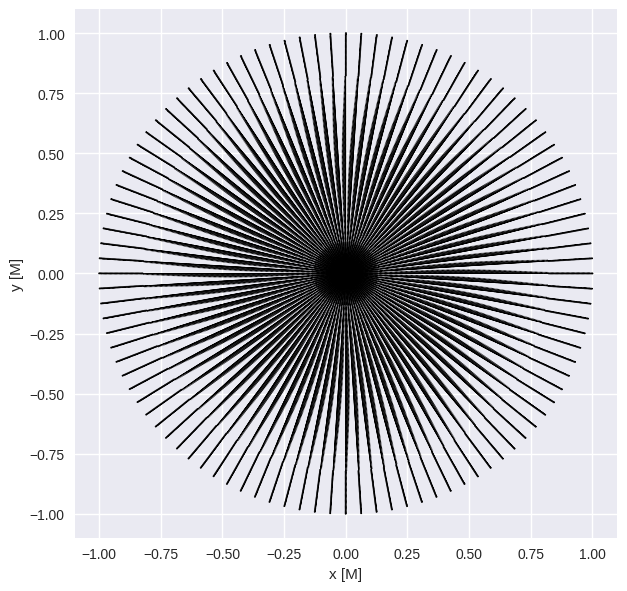

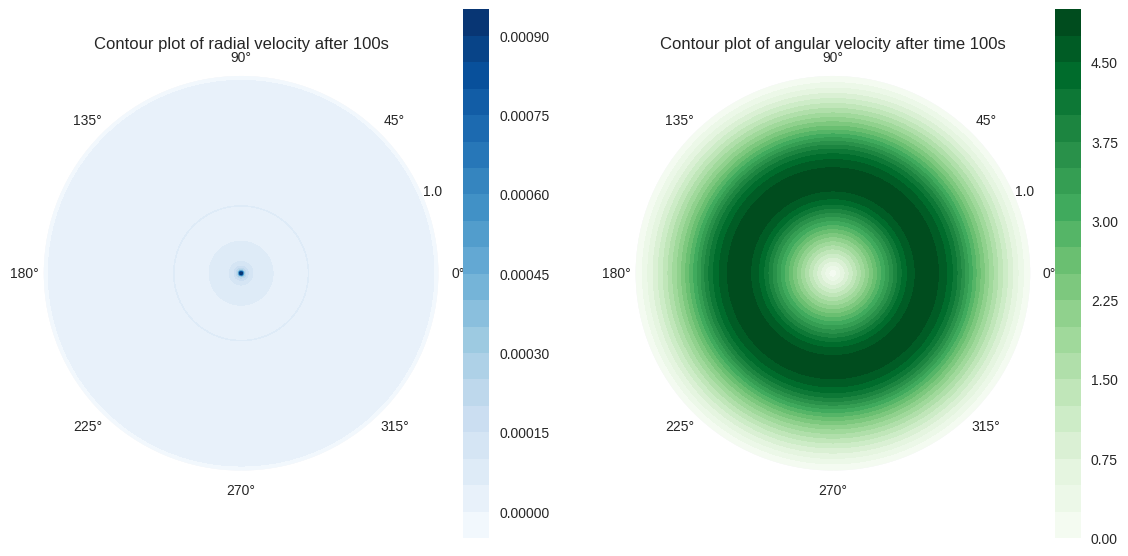

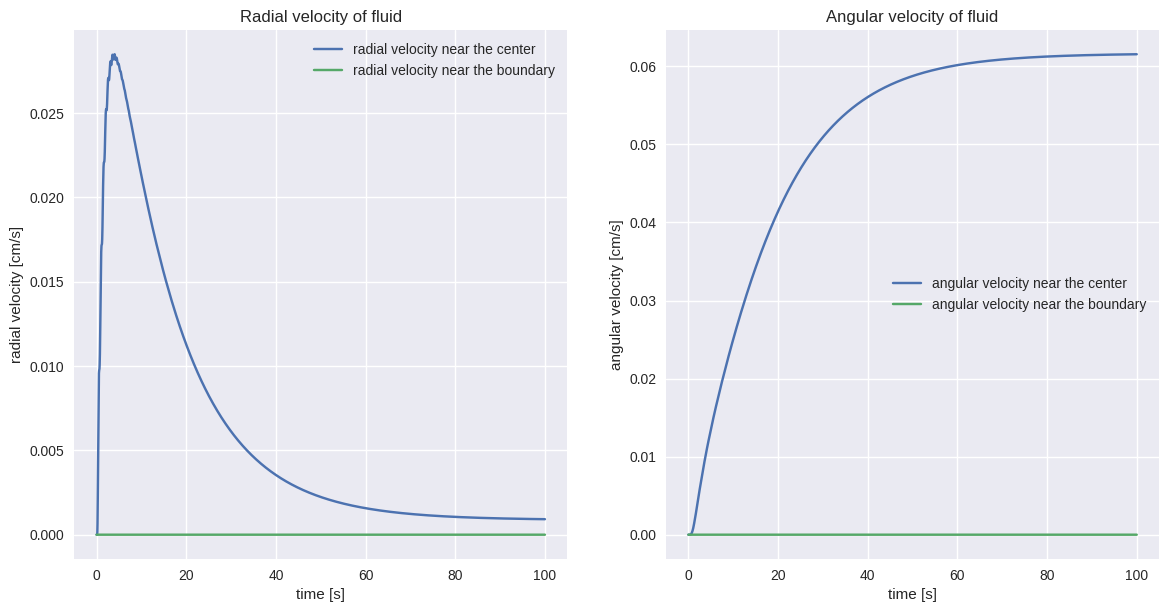

In [0]:
###variable declarations
nr = 200
ntheta = 100
t = 100
omega = 0.005
wind = 1
rho = 1
nu = 0.01

r = np.linspace(0, 1, nr)
theta = np.linspace(0, 2*np.pi-2*np.pi / (ntheta - 1), ntheta)

R, Theta = np.meshgrid(r, theta)

u = np.zeros((ntheta, nr))
v = np.zeros((ntheta, nr))
p = np.zeros((ntheta, nr))

#Assign omega
Omega = np.zeros((ntheta, nr))
G = np.zeros((ntheta, nr))
for i in range(0, nr):
  for j in range(0, ntheta):
    Omega[j][i] = omega*np.sin((r[-1]-r[i])/r[-1]*np.pi/2.)
    if ((r[i]>r[np.int(np.round(nr/3))]) and (r[i]<r[np.int(np.round(nr*2/3))])):
      G[j][i] = wind
    else:
      G[j][i] = 0

###Assign initial conditions
#v[:,int(nr/2):] = 0
#v[:, -1] = 0

#p = rho*(v**2)/2

f = FluidDynamics(r, nr, ntheta, nu, Omega, rho, G)
u, v, p  = f.Chorins_method(t, u, v, p)

f.plot(u, v, R, Theta)
f.equal_check()



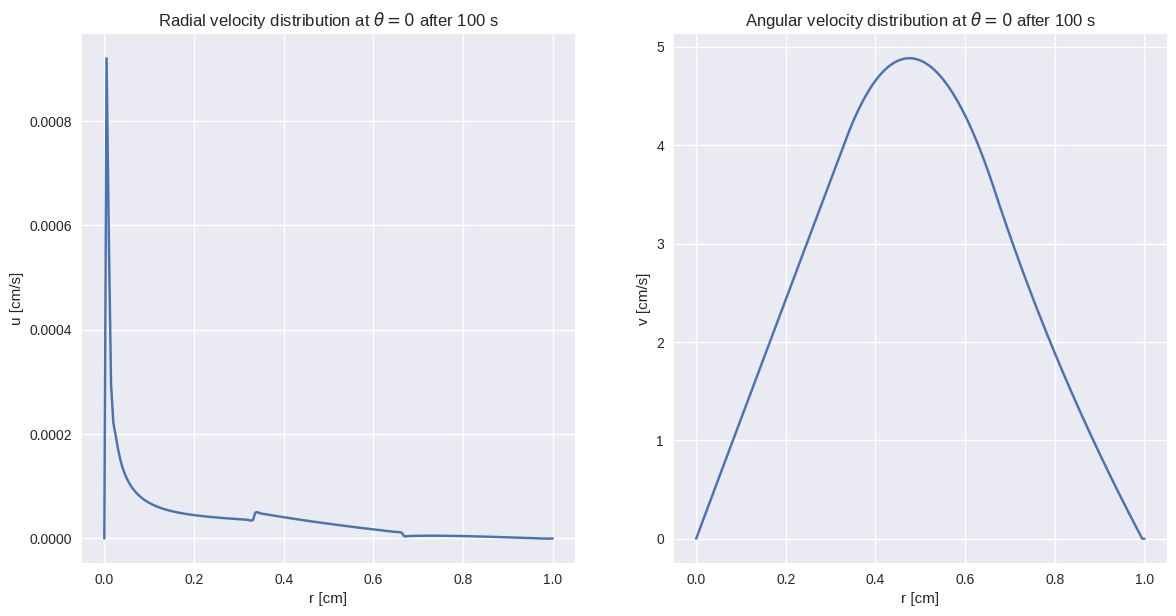

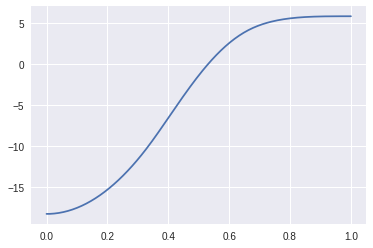

In [0]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7), dpi=100)
    
ax1.plot(r, u[0,:])
ax1.set_title("Radial velocity distribution at $\\theta = 0$ after 100 s")

ax1.set_xlabel("r [cm]")
ax1.set_ylabel("u [cm/s]")

ax2.plot(r, v[0,:])

ax2.set_title("Angular velocity distribution at $\\theta = 0$ after 100 s")

ax2.set_xlabel("r [cm]")
ax2.set_ylabel("v [cm/s]")

#contour2 = ax2.contourf(Theta, R, v, 20, cmap='Greens')
#ax2.set_title("Contour plot of angular velocity after time " + str(self.t) + "s")
#fig.colorbar(contour2, ax=ax2)


plt.show()
    


#t = 50
#u, v, p  = f.Chorins_method(t, u, v, p)

#f.plot(u, v, R, Theta)
#f.equal_check()


plt.plot(r, p[0,:])
plt.figure()

plt.show()
#for i in range(0, nr):
#  for j in range(0, ntheta):
#    Omega[j][i] = omega*np.sin((1-r[i])/r[-1]*np.pi/2.)
#    if ((r[i]>r[np.int(np.round(nr/3))]) & (r[i]<r[np.int(np.round(nr*2/3))])):
#      G[j][i] = wind
#    else:
#      G[j][i] = 0
#
#f = FluidDynamics(r, nr, ntheta, nu, Omega, rho, G)
#t = 1
#u, v, p  = f.Chorins_method(t, u, v, p)

#f.plot(u, v, R, Theta)
#f.equal_check()
#t = 10
#u, v, p  = f.Chorins_method(t, u, v, p)

#f.plot(u, v, R, Theta)
#f.equal_check()
